In [1]:
import tensorflow as tf
import numpy as np
import inceptionv3
from utils import *
from defense import *

In [2]:
sess = tf.Session()

# Image and target class

Choose what you want here.

In [3]:
orig = load_image('cat.jpg')
TARGET = 924 # guacamole
EPSILON = 8.0/255.0

In [4]:
lower = np.clip(orig-EPSILON, 0, 1)
upper = np.clip(orig+EPSILON, 0, 1)

# Classifier

In [5]:
x = tf.placeholder(tf.float32, (299, 299, 3))
x_expanded = tf.expand_dims(x, axis=0)
logits, preds = inceptionv3.model(sess, x_expanded)

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from data/inception_v3.ckpt


In [6]:
probs = tf.nn.softmax(logits)
classify = make_classify(sess, x, probs)

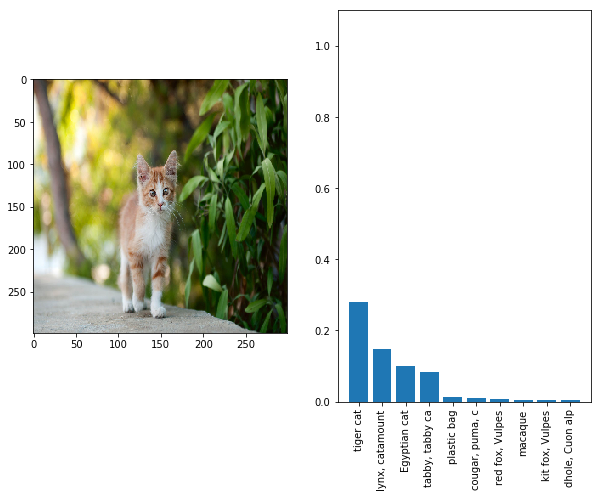

In [7]:
classify(orig, target_class=TARGET)

# Failed attack (attempting to transfer)

In [8]:
loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot(TARGET, 1000))
grad, = tf.gradients(loss, x)

In [9]:
# PGD

LR = 0.1

adv = np.copy(orig)
for i in range(10):
    g, p = sess.run([grad, preds], {x: adv})
    print('step %d, pred=%d' % (i, p))
    # step
    adv -= LR * g
    # project
    adv = np.clip(adv, lower, upper)

step 0, pred=282
step 1, pred=277
step 2, pred=231
step 3, pred=272
step 4, pred=263
step 5, pred=282
step 6, pred=924
step 7, pred=291
step 8, pred=924
step 9, pred=924


In [10]:
cropped_x = defend(x_expanded)
cropped_logits, cropped_preds = inceptionv3.model(sess, cropped_x)

INFO:tensorflow:Scale of 0 disables regularizer.


In [11]:
cropped_probs = tf.nn.softmax(cropped_logits)
cropped_classify = make_classify(sess, x, cropped_probs)

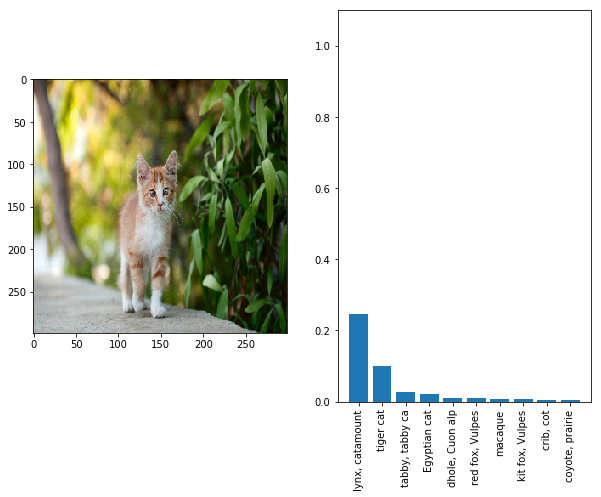

In [12]:
cropped_classify(adv, target_class=TARGET)

# Attack

Using EOT.

In [13]:
ENSEMBLE_SIZE = 30 # larger sample size -> better gradient estimate

In [14]:
ensemble_xs = tf.concat([defend(x_expanded) for _ in range(ENSEMBLE_SIZE)], axis=0)
ensemble_logits, ensemble_preds = inceptionv3.model(sess, ensemble_xs)

INFO:tensorflow:Scale of 0 disables regularizer.


In [15]:
ensemble_labels = tf.tile(tf.expand_dims(tf.one_hot(TARGET, 1000), axis=0), (ensemble_logits.shape[0], 1))
ensemble_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=ensemble_logits, labels=ensemble_labels))
ensemble_grad, = tf.gradients(ensemble_loss, x)

In [16]:
# PGD

LR = 0.1

adv = np.copy(orig)
for i in range(50):
    g, p = sess.run([ensemble_grad, ensemble_preds], {x: adv})
    if i % 10 == 0:
        print('step %d, preds=%s' % (i, p))
    # step
    adv -= LR * g
    # project
    adv = np.clip(adv, lower, upper)

step 0, preds=[287 277 287 287 277 287 287 287 285 287 287 277 287 287 287 287 287 287
 287 287 287 287 274 287 287 277 287 287 287 285]
step 10, preds=[728 924 924 263 263 282 263 282 263 157 924 274 263 924 263 157 274 924
 924 924 274 728 282 263 924 157 728 263 924 282]
step 20, preds=[924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924
 924 924 924 924 924 924 924 924 924 924 924 924]
step 30, preds=[924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924
 924 924 924 924 924 924 924 924 924 924 924 924]
step 40, preds=[924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924
 924 924 924 924 924 924 924 924 924 924 924 924]


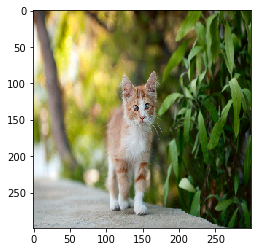

In [17]:
plt.imshow(adv)

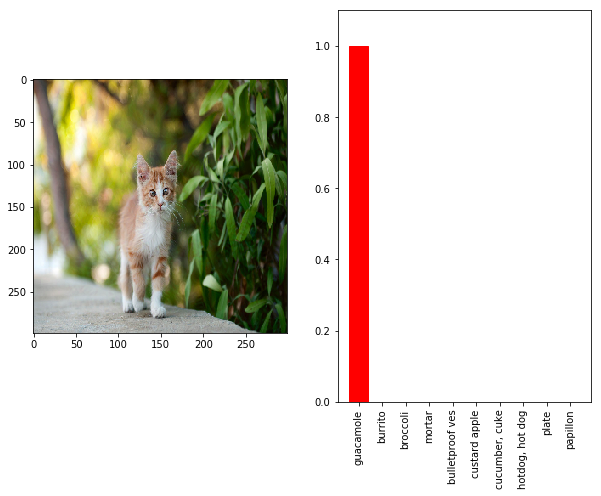

In [18]:
cropped_classify(adv, target_class=TARGET)